In [1]:
### IMPORTANT!!!
# Due to some environment bug. tensorrt cannot be found while python is launched in Chilung/tensorrt working directory.
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from __future__ import print_function, division

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
print(torch.__version__)

1.0.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
import matplotlib.patches as mpatches

from torch.autograd import Variable
import torch
import math

import os
import sys
import re
from collections import OrderedDict

def test_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_time = OrderedDict()
    
    with open(fname) as fp:  
        for cnt, line in enumerate(fp):
            print("Line {}: {}".format(cnt, line))
            # batch size: 2
            pattern = re.compile(r"batch size: (\d+)")
            match = pattern.match(line)
            if match:
                batch_size_str, = match.groups()
                print(batch_size_str)
                      
            # Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.004
            pattern = re.compile(r"Accuracy of the network on the (\d+) test images: (\d+.\d+)%, and loss is: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                test_size_str, acc_str, loss_str = match.groups()
                print(test_size_str, acc_str, loss_str)

            # 76.6552894115448 seconds
            pattern = re.compile(r"(\d+.\d+) seconds")
            match = pattern.match(line)
            if match:
                time_str, = match.groups()
                print(time_str)
                print('batch: {:s}, acc: {:s}, time: {:s}'.
                      format(batch_size_str, acc_str, time_str))

                batch = int(math.log(int(batch_size_str), 2))
                acc = float("{:.2f}".format(float(acc_str)))
                time = float("{:.2f}".format(float(time_str)))
                
                dictionary_acc[batch] = acc
                dictionary_time[batch] = time
                    
    return dictionary_acc, dictionary_time

In [12]:
pytorch_gpu_acc, pytorch_gpu_time = test_result("pytorch-gpu-test-result.log")
rt_acc, rt_time = test_result("rt.log")

Line 0: batch size: 2

2
Line 1: test data set: test

Line 2: 

Line 3: /home/ccma/n1p1/home/ccma/Chilung/lab5-venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number

Line 4: 

Line 5: Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.118

3347 92.41 0.118
Line 6: Accuracy of Bread : 88 %

Line 7: Accuracy of DairyProduct : 81 %

Line 8: Accuracy of Dessert : 97 %

Line 9: Accuracy of   Egg : 88 %

Line 10: Accuracy of Friedfood : 92 %

Line 11: Accuracy of  Meat : 91 %

Line 12: Accuracy of Noodles-Pasta : 92 %

Line 13: Accuracy of  Rice : 98 %

Line 14: Accuracy of Seafood : 98 %

Line 15: Accuracy of  Soup : 91 %

Line 16: Accuracy of Vegetable-Fruit : 97 %

Line 17: 41.08022952079773 seconds

41.08022952079773
batch: 2, acc: 92.41, time: 41.08022952079773
Line 18: batch size: 4

4
Line 19: test data set: test



In [19]:
import matplotlib.pyplot as plt
import itertools

def show_test_result(pytorch_gpu_acc, pytorch_gpu_time,
                     rt_acc, rt_time):
    
    print('Pytorch GPU Inference Time')
    print(pytorch_gpu_time)
    print('Pytorch GPU Accuracy')
    print(pytorch_gpu_acc)
    print('TensorRT Inference Time')
    print(rt_time)
    print('TensorRT Accuracy')
    print(rt_acc)
        
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('TensorRT Inference Accuracy and Inference Time', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    l1, = ax1.plot(list(pytorch_gpu_time.keys()), list(pytorch_gpu_time.values()), 'r--')
    for i, j in zip(list(pytorch_gpu_time.keys()), list(pytorch_gpu_time.values())):
        ax1.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, 20), textcoords='offset points', color='r', fontsize=20)
    
    l3, = ax1.plot(list(rt_time.keys()), list(rt_time.values()), 'b--')
    for i, j in zip(list(rt_time.keys()), list(rt_time.values())):
        ax1.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, 20), textcoords='offset points', color='b', fontsize=20)
    
    l4, = ax2.plot(list(pytorch_gpu_acc.keys()), list(pytorch_gpu_acc.values()), 'r-')
    for i, j in zip(list(pytorch_gpu_acc.keys()), list(pytorch_gpu_acc.values())):
        ax2.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, -20), textcoords='offset points', color='r', fontsize=20)
    
    l6, = ax2.plot(list(rt_acc.keys()), list(rt_acc.values()), 'b-')
    for i, j in zip(list(rt_acc.keys()), list(rt_acc.values())):
        ax2.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, -20), textcoords='offset points', color='b', fontsize=20)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Batch Size (power of 2)', fontsize=20)
    ax1.set_ylabel('Second', fontsize=20, color='r')
    ax2.set_ylabel('Accuracy (%)', fontsize=20, color='b')
    
    ax2.set(ylim=[0, 100])
    
    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l3, l4, l6],
               labels=['Pytorch GPU Inference Time', 'TensorRT Inference Time',
                       'Pytorch GPU Accuracy', 'TensorRT Accuracy'],
               fontsize=20, loc='right')

    plt.show()

Pytorch GPU Inference Time
OrderedDict([(1, 41.08), (2, 39.72), (3, 39.41), (4, 39.81), (5, 38.88), (6, 39.16), (7, 39.11), (8, 39.51)])
Pytorch GPU Accuracy
OrderedDict([(1, 92.41), (2, 92.41), (3, 92.41), (4, 92.41), (5, 92.41), (6, 92.41), (7, 92.41), (8, 92.41)])
TensorRT Inference Time
OrderedDict([(1, 41.17), (2, 40.0), (3, 39.39), (4, 38.81), (5, 38.63), (6, 39.94), (7, 39.41), (8, 39.36)])
TensorRT Accuracy
OrderedDict([(1, 92.41), (2, 92.41), (3, 92.41), (4, 92.41), (5, 92.41), (6, 92.41), (7, 92.41), (8, 92.41)])


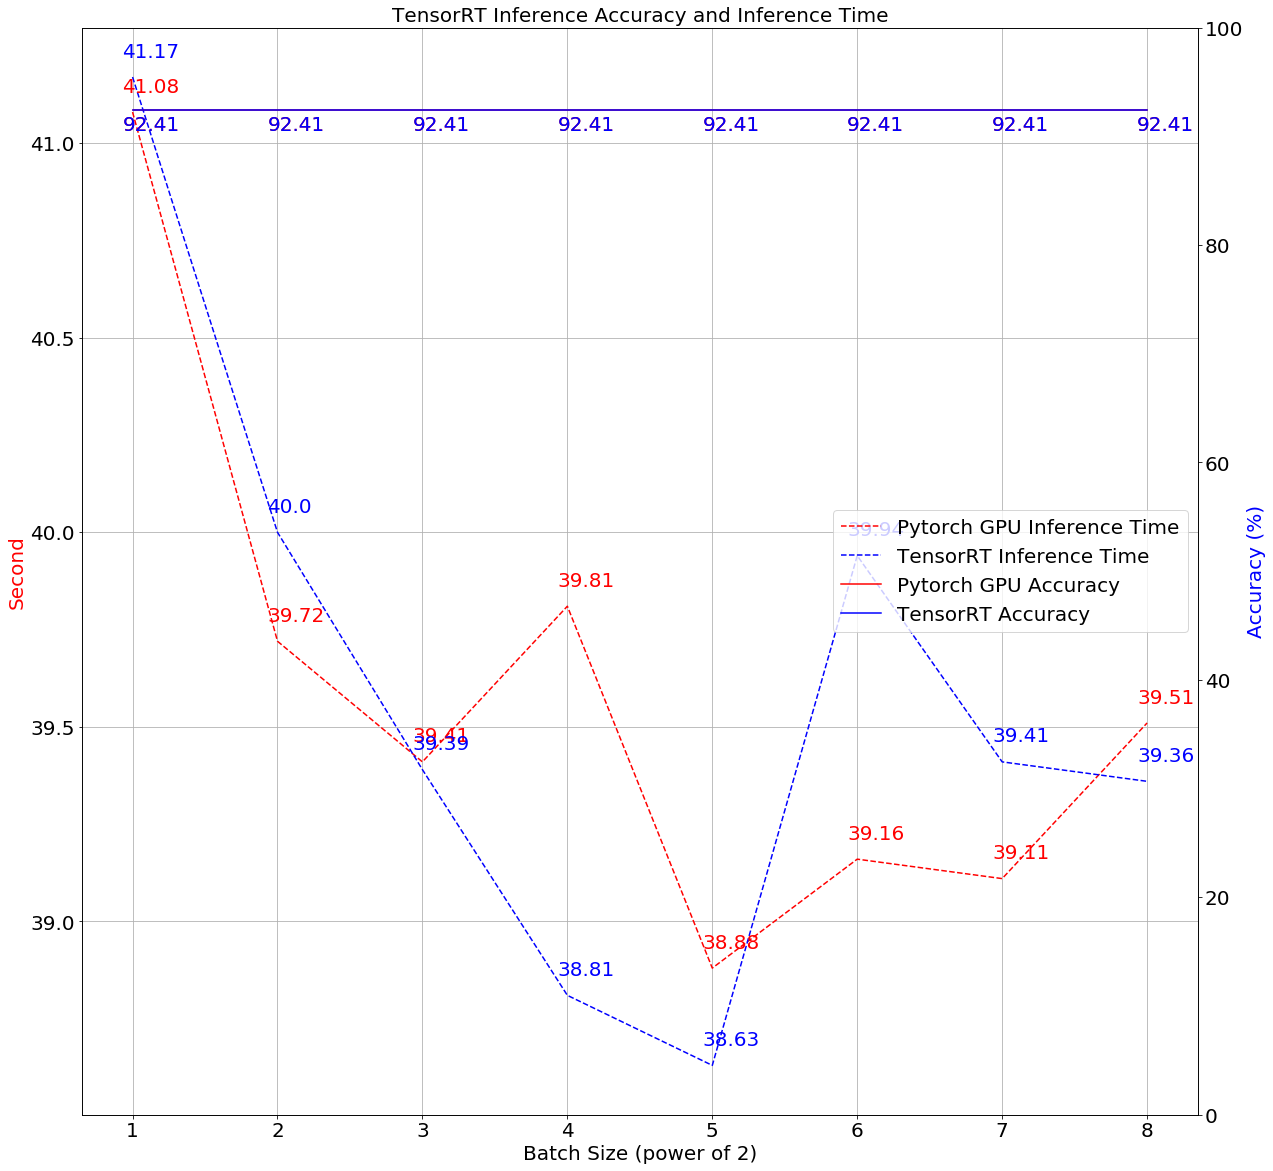

In [18]:
show_test_result(pytorch_gpu_acc, pytorch_gpu_time,
                     rt_acc, rt_time)